### i. Initialize project

In [220]:
import pandas as pd
import numpy as np        
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, make_scorer, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.decomposition import PCA


from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

#import file
banks_df = pd.read_csv('../data/bank-additional/bank-additional-full.csv', sep=';')


### ii. Preprocess Data

In [10]:
# prep data for pipeline
df = banks_df.copy()
df = df.drop(["day_of_week", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m","nr.employed","duration", "housing"], axis=1)

# Bin education to save dimensions
df["education"] = df["education"].map({
    "basic.4y": "primary",
    "basic.6y": "primary",
    "basic.9y": "secondary",
    "high.school": "secondary",
    "university.degree": "tertiary",
    "professional.course": "other",
    "unknown": "other",
    "illiterate": "other"
})
df['job'] = df['job'].replace('admin.', 'admin')

# Make varible for prior contact status
# set pdays null values to NAs
df['pdays'] = df['pdays'].replace(999, np.nan) 
# transform pdays to bins, since range 0-27, use 3 bins
df['pdays'] = pd.qcut(df['pdays'], q=3, labels=[1,2,3])

df['pdays'] = df['pdays'].cat.add_categories([-1])
df['pdays'] = df['pdays'].fillna(-1)


# split categorical and numerical features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'y']
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('y')

# enforce that object types are treated as categorical
for col in categorical_cols:
    df[col] = df[col].astype('category')

   

In [ ]:
#split our data
X = df.drop(['y'], axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

In [ ]:
# preprocessor for pipeline
preprocessor =ColumnTransformer(
    transformers=[
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), numeric_cols)
    ])

### 1.0 Building Baseline SVM Model

In [173]:
# Init pipeline: Preprocessing -> SMOTE -> SVM with random tuning params 
svm0_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=13)), 
    ('svm', SVC(kernel='rbf', C=.1, gamma='scale', probability=True))
])

# Train our model
svm0_pipe.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [141]:
# Helpers: use pipeline to preprocess X df and set to new df
# X_preprocessed = svm0_pipe.named_steps['preprocessor'].transform(X_train)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# use pipeline to balance data and return new dfs
X_resampled, y_resampled = svm0_pipe.named_steps['smote'].fit_resample(X_train_preprocessed, y_train)


#### 1.0a Visualing Data with PCA

To get a sense of which kernel to use in our model, let's use PCA to visualize our data in 2 dimensions.

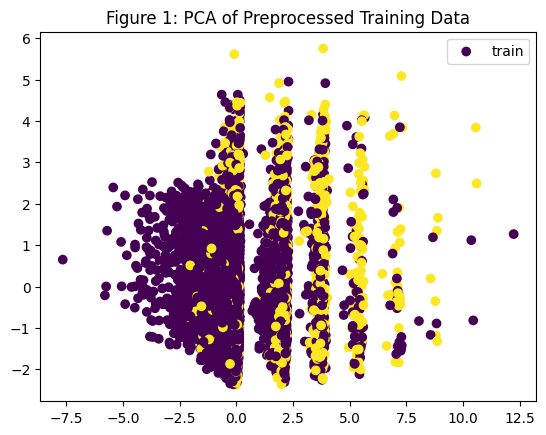

In [192]:
# Use PCA to visualize in 2 dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_preprocessed) 

# now plot
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train.map({'no': 0, 'yes': 1}), label='train')
plt.title("Figure 1: PCA of Preprocessed Training Data")
plt.legend()
plt.show()



#### 1.0b Visualize data with t-SNE

The PCA plot above shows clear banding as a result of using one-hot encoded categorical variables instead of numerical variables. t-SNE can use a mix of categorical and numerical in order to continue to use our pipeline for preprocessing. 

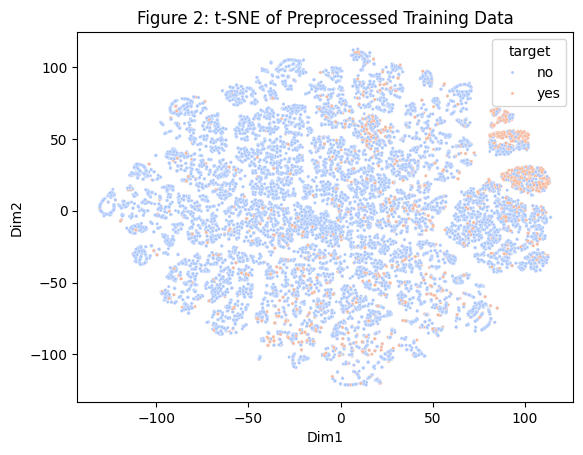

In [191]:
# Use t-SNE to visualize data in 2 dimensions
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, random_state=13, perplexity=30).fit_transform(X_train_preprocessed)
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1','Dim2'])
tsne_df['target'] = y_train.values

# now plot
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='target', palette='coolwarm', s=5)
plt.title("Figure 2: t-SNE of Preprocessed Training Data")
plt.show()


t-SNE visualization shows non-linear overlapping cloud suggesting RBF may be better kernel fit.

### 1.1 Hyperparameter Tuning

We will use Cross-Validation to test different tuning parameters: kernels (rbf/linear), cost penalties C (0.1, 1, 10) and gammas (scale, 0.1, 0.01).

In [230]:
# use cross validation to tune

kernels = ['rbf', 'poly']
Cs = [0.1, 1, 10]
gammas = ['scale', 0.1, 0.01]

results1 = []
f1_yes = make_scorer(f1_score, pos_label='yes')

# test our tuning parameters
for test_kernel, test_C, test_gamma in product(kernels, Cs, gammas):

    pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=13)), 
        ('svm', SVC(kernel=test_kernel, C=test_C, gamma=test_gamma))
    ])

    # get accuracy and f1 score using 5-fold CV
    scores = cross_validate(
        pipe,
        X_train, y_train,
        cv=5,
        scoring={'accuracy': 'accuracy', 'recall_yes': make_scorer(recall_score, pos_label='yes'), 'f1_yes': f1_yes },
        n_jobs=-1
    )

    results1.append({
        'kernel': test_kernel,
        'C': test_C,
        'gamma': test_gamma,
        'accuracy': scores['test_accuracy'].mean(),
        'recall_yes': scores['test_recall_yes'].mean(),
        'f1_mean': scores['test_f1_yes'].mean()
    })
    print(f"kernel={test_kernel}, C={test_C}, gamma={test_gamma} → mean F1={scores['test_f1_yes'].mean():.3f}")



kernel=rbf, C=0.1, gamma=scale → mean F1=0.415
kernel=rbf, C=0.1, gamma=0.1 → mean F1=0.411
kernel=rbf, C=0.1, gamma=0.01 → mean F1=0.375
kernel=rbf, C=1, gamma=scale → mean F1=0.398
kernel=rbf, C=1, gamma=0.1 → mean F1=0.395
kernel=rbf, C=1, gamma=0.01 → mean F1=0.420
kernel=rbf, C=10, gamma=scale → mean F1=0.365
kernel=rbf, C=10, gamma=0.1 → mean F1=0.358
kernel=rbf, C=10, gamma=0.01 → mean F1=0.434
kernel=poly, C=0.1, gamma=scale → mean F1=0.416
kernel=poly, C=0.1, gamma=0.1 → mean F1=0.413
kernel=poly, C=0.1, gamma=0.01 → mean F1=0.162
kernel=poly, C=1, gamma=scale → mean F1=0.385
kernel=poly, C=1, gamma=0.1 → mean F1=0.385
kernel=poly, C=1, gamma=0.01 → mean F1=0.374
kernel=poly, C=10, gamma=scale → mean F1=0.370
kernel=poly, C=10, gamma=0.1 → mean F1=0.364
kernel=poly, C=10, gamma=0.01 → mean F1=0.384


In [241]:

kernels = ['linear']
Cs = [0.1, 1, 10]
gammas = ['scale', 0.1, 0.01]

f1_yes = make_scorer(f1_score, pos_label='yes')

# test our tuning parameters
for test_kernel, test_C, test_gamma in product(kernels, Cs, gammas):

    pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=13)), 
        ('svm', SVC(kernel=test_kernel, C=test_C, gamma=test_gamma))
    ])

    # get accuracy and f1 score using 5-fold CV
    scores = cross_validate(
        pipe,
        X_train, y_train,
        cv=5,
        scoring={'accuracy': 'accuracy', 'recall_yes': make_scorer(recall_score, pos_label='yes'), 'f1_yes': f1_yes },
        n_jobs=-1
    )

    results1.append({
        'kernel': test_kernel,
        'C': test_C,
        'gamma': test_gamma,
        'accuracy': scores['test_accuracy'].mean(),
        'recall_yes': scores['test_recall_yes'].mean(),
        'f1_mean': scores['test_f1_yes'].mean()
    })
    print(f"kernel={test_kernel}, C={test_C}, gamma={test_gamma} → mean F1={scores['test_f1_yes'].mean():.3f}")


kernel=linear, C=0.1, gamma=scale → mean F1=0.399
kernel=linear, C=0.1, gamma=0.1 → mean F1=0.399
kernel=linear, C=0.1, gamma=0.01 → mean F1=0.399
kernel=linear, C=1, gamma=scale → mean F1=0.398
kernel=linear, C=1, gamma=0.1 → mean F1=0.398
kernel=linear, C=1, gamma=0.01 → mean F1=0.398
kernel=linear, C=10, gamma=scale → mean F1=0.398
kernel=linear, C=10, gamma=0.1 → mean F1=0.398
kernel=linear, C=10, gamma=0.01 → mean F1=0.398


In [242]:
cv_results_df = pd.DataFrame(results1)
print('Table 2:  CV Results for Tuning Parameters')
print(cv_results_df)

Table 2:  CV Results for Tuning Parameters
    kernel     C  gamma  accuracy  recall_yes   f1_mean
0      rbf   0.1  scale  0.823523    0.555415  0.415469
1      rbf   0.1    0.1  0.819569    0.557877  0.411137
2      rbf   0.1   0.01  0.782248    0.579734  0.375236
3      rbf   1.0  scale  0.829593    0.499683  0.398122
4      rbf   1.0    0.1  0.829142    0.495066  0.395357
5      rbf   1.0   0.01  0.837154    0.522773  0.419903
6      rbf  10.0  scale  0.846138    0.393160  0.365403
7      rbf  10.0    0.1  0.842912    0.388236  0.357753
8      rbf  10.0   0.01  0.852381    0.500918  0.434025
9     poly   0.1  scale  0.826541    0.547102  0.415986
10    poly   0.1    0.1  0.822344    0.552644  0.412550
11    poly   0.1   0.01  0.890708    0.094215  0.162249
12    poly   1.0  scale  0.808366    0.531400  0.384918
13    poly   1.0    0.1  0.813465    0.518162  0.385295
14    poly   1.0   0.01  0.853976    0.387000  0.373749
15    poly  10.0  scale  0.842843    0.408866  0.369619
16   

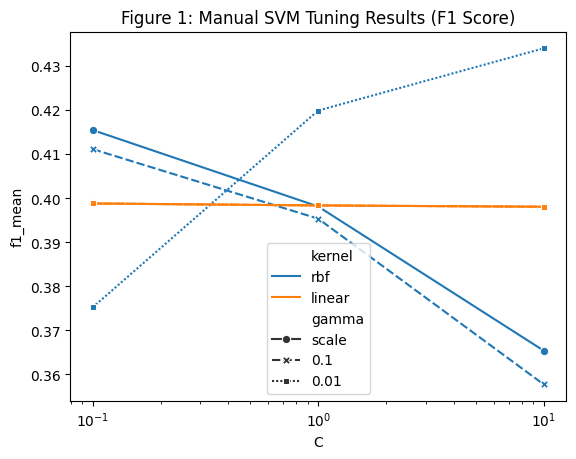

In [ ]:
# show f1 chart

sns.lineplot(data=cv_results_df, x='C', y='f1_mean', hue='kernel', style='gamma', markers=True)
plt.xscale('log')
plt.title('Figure 1: Manual SVM Tuning Results (F1 Score)')
plt.show()

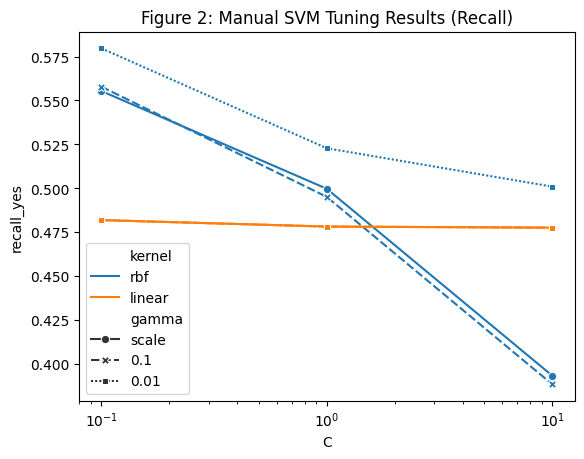

In [ ]:
# show recal chart
sns.lineplot(data=cv_results_df, x='C', y='recall_yes', hue='kernel', style='gamma', markers=True)
plt.xscale('log')
plt.title('Figure 2: Manual SVM Tuning Results (Recall)')
plt.show()

k-fold CV tests for kernel, gamma, and cost (C) confirm that RBF is a better fit on recall and perform better than linear model with a gamma of 0.01. However, all models yield relatively weak F1 Scores, maybe due to noise from SMOTE and/or to one-hot encoding. This test shows the model with the highest F1 score used an RBF kernel, C=10 and gamma=0.01 (model svm2_pipe). Our baseline model (svm1_pipe) conincidentally had the highest Recall value (0.579734) and used an RBF kernel, C=0.1 with a gamma=0.01.

Next, we will try to do perfom feature selection based on important features to see if we get better results.

In [174]:
# Best Recall model

svm1_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=13)), 
    ('svm', SVC(kernel='rbf', C=0.1, gamma=0.01, probability=True))
])

# Train our model
svm1_pipe.fit(X_train, y_train)


# Best F1 model

svm2_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=13)), 
    ('svm', SVC(kernel='rbf', C=10, gamma=0.01, probability=True))
])

# Train our model
svm2_pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
# eval SVM1 using test set
svm1_y_pred = svm1_pipe.predict(X_test)

print('Confusion Matrix for SVM1 e\n', confusion_matrix(y_test, svm1_y_pred))
print("\nAccuracy:", accuracy_score(y_test, svm1_y_pred))
print("\nClassification Report:\n", classification_report(y_test, svm1_y_pred))



Confusion Matrix for SVM1 e
 [[9141 1824]
 [ 589  803]]

Accuracy: 0.804726066197297

Classification Report:
               precision    recall  f1-score   support

          no       0.94      0.83      0.88     10965
         yes       0.31      0.58      0.40      1392

    accuracy                           0.80     12357
   macro avg       0.62      0.71      0.64     12357
weighted avg       0.87      0.80      0.83     12357



<positron-console-cell-201>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [232]:
svm1_y_pred_proba = svm1_pipe.predict_proba(X_test)[:, 1]
y_true = y_test.map({'no': 0, 'yes': 1})
eval_df = pd.DataFrame(columns=['model_name', 'accuracy', 'recall_no', 'recall_yes', 'f1_no', 'f1_yes','auc','auprc'])

# append to our evaluation table
report_svm1 = classification_report(y_test, svm1_y_pred, output_dict=True)
results_svm1 = pd.DataFrame([{
    'model_name': 'SVM 1', 
    'accuracy': report_svm1['accuracy'],       
    'recall_no': report_svm1['no']['recall'],    
    'recall_yes': report_svm1['yes']['recall'],  
    'f1_no': report_svm1['no']['f1-score'],    
    'f1_yes': report_svm1['yes']['f1-score'],
    'auc': roc_auc_score(y_test, svm1_y_pred_proba),
    'auprc' : average_precision_score(y_true, svm1_y_pred_proba)  
}])
eval_df = pd.concat([eval_df, results_svm1], ignore_index=True)

<positron-console-cell-232>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [202]:
# eval SVM2 using test set
svm2_y_pred = svm2_pipe.predict(X_test)

print('Confusion Matrix for SVM1 e\n', confusion_matrix(y_test, svm2_y_pred))
print("\nAccuracy:", accuracy_score(y_test, svm2_y_pred))
print("\nClassification Report:\n", classification_report(y_test, svm2_y_pred))


Confusion Matrix for SVM1 e
 [[9880 1085]
 [ 660  732]]

Accuracy: 0.8587844946184349

Classification Report:
               precision    recall  f1-score   support

          no       0.94      0.90      0.92     10965
         yes       0.40      0.53      0.46      1392

    accuracy                           0.86     12357
   macro avg       0.67      0.71      0.69     12357
weighted avg       0.88      0.86      0.87     12357



<positron-console-cell-202>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [233]:
svm2_y_pred_proba = svm2_pipe.predict_proba(X_test)[:, 1]

# append to our evaluation table
report_svm2 = classification_report(y_test, svm2_y_pred, output_dict=True)
results_svm2 = pd.DataFrame([{
    'model_name': 'SVM 2', 
    'accuracy': report_svm2['accuracy'],       
    'recall_no': report_svm2['no']['recall'],    
    'recall_yes': report_svm2['yes']['recall'],  
    'f1_no': report_svm2['no']['f1-score'],    
    'f1_yes': report_svm2['yes']['f1-score'],
    'auc': roc_auc_score(y_test, svm2_y_pred_proba),
    'auprc' : average_precision_score(y_true, svm2_y_pred_proba)
}])
eval_df = pd.concat([eval_df, results_svm2], ignore_index=True)

In [219]:
print(eval_df)

  model_name  accuracy  recall_no  recall_yes     f1_no    f1_yes       auc     auprc
0      SVM 1  0.804726   0.833653    0.576868  0.883402  0.399602  0.760356  0.380418


#### 1.3 Refining Feature Selection

In [188]:
# get import features
from sklearn.inspection import permutation_importance
feature_names = svm1_pipe.named_steps['preprocessor'].get_feature_names_out()

pi_result = permutation_importance(
    svm1_pipe.named_steps['svm'],   
    X_test_preprocessed,
    y_test,
    scoring=f1_yes,
    n_repeats=5,
    random_state=13
)

In [ ]:
# print important features
importances = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': pi_result.importances_mean,
    'importance_std': pi_result.importances_std
}).sort_values('importance_mean', ascending=False)
importances.reset_index(drop=True, inplace=True)

print('Table 2: Feature Importance in Best Recall Model (svm1)')
print(importances.head(15))

                  feature  importance_mean  importance_std
0          cat__month_aug         0.039860        0.000819
1          cat__month_jul         0.037865        0.001963
2          cat__month_nov         0.037145        0.001265
3           num__previous         0.020579        0.002698
4          cat__month_may         0.017056        0.003636
5   cat__poutcome_failure         0.008689        0.000722
6                num__age         0.008566        0.001790
7          cat__month_oct         0.005925        0.000785
8          cat__month_mar         0.004555        0.001038
9           cat__pdays_-1         0.003542        0.000737
10       cat__job_student         0.003541        0.000146
11       cat__job_retired         0.003429        0.001215
12         cat__month_jun         0.002976        0.000871
13  cat__poutcome_success         0.002556        0.000660
14         cat__month_sep         0.002495        0.000864


Create new model from most important features

In [ ]:
# new model 
top_features = importances.query('importance_mean > 0.025')['feature']

X_train_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

X_train_top = X_train_df[top_features]
X_test_top = X_test_df[top_features]

svm1_best_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=13)), 
    ('svm', SVC(kernel='rbf', C=10, gamma=0.01, probability=True))
])
svm1_best_pipe.fit(X_train_top, y_train)

,steps,"[('smote', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,13
,k_neighbors,5
,C,10
,kernel,'rbf'
,degree,3
,gamma,0.01


In [163]:
# use most important features to tune model
# use cross-validation to check if there are performace increases 
kernels = ['rbf']
Cs = [0.1, 1, 10]
gammas = ['scale', 0.1, 0.01]

results2 = []
f1_yes = make_scorer(f1_score, pos_label='yes')

# test our tuning parameters
for test_kernel, test_C, test_gamma in product(kernels, Cs, gammas):

    pipe = ImbPipeline([
        ('smote', SMOTE(random_state=13)), 
        ('svm', SVC(kernel=test_kernel, C=test_C, gamma=test_gamma))
    ])

    # get accuracy and f1 score using 5-fold CV
    scores = cross_validate(
        pipe,
        X_train_top, y_train,
        cv=5,
        scoring={'accuracy': 'accuracy', 'recall_yes': make_scorer(recall_score, pos_label='yes'), 'f1_yes': f1_yes },
        n_jobs=-1
    )

    results2.append({
        'kernel': test_kernel,
        'C': test_C,
        'gamma': test_gamma,
        'accuracy': scores['test_accuracy'].mean(),
        'recall_yes': scores['test_recall_yes'].mean(),
        'f1_mean': scores['test_f1_yes'].mean()
    })
    print(f"kernel={test_kernel}, C={test_C}, gamma={test_gamma} → mean F1={scores['test_f1_yes'].mean():.3f}")


kernel=rbf, C=0.1, gamma=scale → mean F1=0.345
kernel=rbf, C=0.1, gamma=0.1 → mean F1=0.330
kernel=rbf, C=0.1, gamma=0.01 → mean F1=0.363
kernel=rbf, C=1, gamma=scale → mean F1=0.367
kernel=rbf, C=1, gamma=0.1 → mean F1=0.330
kernel=rbf, C=1, gamma=0.01 → mean F1=0.322
kernel=rbf, C=10, gamma=scale → mean F1=0.363
kernel=rbf, C=10, gamma=0.1 → mean F1=0.346
kernel=rbf, C=10, gamma=0.01 → mean F1=0.326


In [164]:

print(pd.DataFrame(results2))

  kernel     C  gamma  accuracy  recall_yes   f1_mean
0    rbf   0.1  scale  0.772467    0.529228  0.344748
1    rbf   0.1    0.1  0.741598    0.565269  0.330177
2    rbf   0.1   0.01  0.845375    0.390993  0.362978
3    rbf   1.0  scale  0.809510    0.490760  0.367266
4    rbf   1.0    0.1  0.742638    0.563113  0.330226
5    rbf   1.0   0.01  0.743540    0.540022  0.321814
6    rbf  10.0  scale  0.803163    0.497843  0.363015
7    rbf  10.0    0.1  0.773856    0.524904  0.345746
8    rbf  10.0   0.01  0.743262    0.552028  0.326380


In [ ]:
# use tuning parameters from above
svm3_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=13)), 
    ('svm', SVC(kernel='rbf', C=0.1, gamma=0.01, probability=True))
])

# Train our model
svm3_pipe.fit(X_train_top, y_train)

,steps,"[('smote', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,13
,k_neighbors,5
,C,0.1
,kernel,'rbf'
,degree,3
,gamma,0.01


In [213]:
# eval SVM3 using test set
svm3_y_pred = svm3_pipe.predict(X_test_top)

print('Confusion Matrix for SVM1 e\n', confusion_matrix(y_test, svm3_y_pred))
print("\nAccuracy:", accuracy_score(y_test, svm3_y_pred))
print("\nClassification Report:\n", classification_report(y_test, svm3_y_pred))



Confusion Matrix for SVM1 e
 [[9465 1500]
 [ 726  666]]

Accuracy: 0.8198591891235737

Classification Report:
               precision    recall  f1-score   support

          no       0.93      0.86      0.89     10965
         yes       0.31      0.48      0.37      1392

    accuracy                           0.82     12357
   macro avg       0.62      0.67      0.63     12357
weighted avg       0.86      0.82      0.84     12357



In [234]:
svm3_y_pred_proba = svm3_pipe.predict_proba(X_test_top)[:, 1]

# append to our evaluation table
report_svm3 = classification_report(y_test, svm3_y_pred, output_dict=True)
results_svm3 = pd.DataFrame([{
    'model_name': 'SVM 3', 
    'accuracy': report_svm3['accuracy'],       
    'recall_no': report_svm3['no']['recall'],    
    'recall_yes': report_svm3['yes']['recall'],  
    'f1_no': report_svm3['no']['f1-score'],    
    'f1_yes': report_svm3['yes']['f1-score'],
    'auc': roc_auc_score(y_test, svm3_y_pred_proba),
    'auprc' : average_precision_score(y_true, svm3_y_pred_proba)
}])
eval_df = pd.concat([eval_df, results_svm3], ignore_index=True)

In [235]:
print(eval_df)

  model_name  accuracy  recall_no  recall_yes     f1_no    f1_yes       auc     auprc
0      SVM 1  0.804726   0.833653    0.576868  0.883402  0.399602  0.760356  0.380418
1      SVM 2  0.858784   0.901049    0.525862  0.918856  0.456217  0.762382  0.384800
2      SVM 3  0.819859   0.863201    0.478448  0.894782  0.374368  0.721687  0.326938


### 2. Model Comparison

In [236]:
# merge eval tables from Assigment 2 and 3
assignment2_eval_df = pd.read_pickle("../eval_df.pkl")
final_eval_df = pd.concat([eval_df, assignment2_eval_df], ignore_index=True)
final_eval_df.drop(columns=['recall_no', 'f1_no'], inplace=True)
print(final_eval_df)

   model_name  accuracy  recall_yes    f1_yes       auc     auprc
0       SVM 1  0.804726    0.576868  0.399602  0.760356  0.380418
1       SVM 2  0.858784    0.525862  0.456217  0.762382  0.384800
2       SVM 3  0.819859    0.478448  0.374368  0.721687  0.326938
3     DT Base  0.830460    0.312500  0.293423  0.605826  0.174159
4        DT 1  0.848345    0.504310  0.428310  0.752236  0.348789
5        DT 2  0.859675    0.466236  0.428100  0.727157  0.333665
6        DT 3  0.528688    0.778017  0.271089  0.680707  0.240591
7     RF Base  0.863235    0.368534  0.377761  0.735150  0.310198
8        RF 1  0.869629    0.290948  0.334572  0.727504  0.309402
9        RF 2  0.871409    0.308908  0.351164  0.732431  0.314691
10   Ada Base  0.888565    0.346983  0.412292  0.753653  0.383261
11      Ada 1  0.891317    0.304598  0.387038  0.763200  0.389658
12      Ada 2  0.890669    0.317529  0.395526  0.762900  0.393265
13      Ada 3  0.879501    0.407328  0.432329  0.754521  0.383991


In [238]:
# Import models from Assignment 2 
import joblib

# disqualify dt0 because likely overfitted
# disqualify dt3 because underperfoms after pruning
# best
dt1 = joblib.load('../models/bank_dt1.pkl')

# disqualify rf0 because of possible data leakage from not using pipeline
# best
rf2_pipe = joblib.load('../models/bank_rf2.pkl')

# best
ada1_pipe = joblib.load('../models/bank_ada1_pipe.pkl')
ada2_pipe = joblib.load('../models/bank_ada2_pipe.pkl')
ada3_pipe = joblib.load('../models/bank_ada3_pipe.pkl')

Show AUROC AUPRC for 'best' models

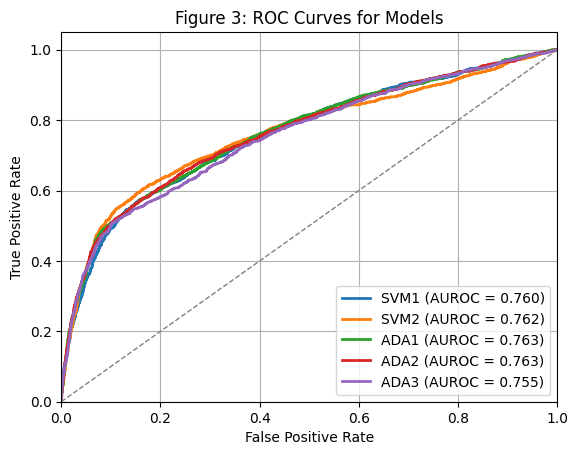

         AUROC
ADA1  0.763200
ADA2  0.762900
SVM2  0.762382
SVM1  0.760356
ADA3  0.754521


In [239]:
# Plot AUROC curve

#'DT': dt1,
models = {'SVM1': svm1_pipe, 'SVM2': svm2_pipe, 'ADA1': ada1_pipe, 'ADA2': ada2_pipe, 'ADA3': ada3_pipe}
auroc_results = {}
y_true = y_test.map({'no': 0, 'yes': 1})


for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1] 
    elif hasattr(model, "decision_function"): 
        y_scores = model.decision_function(X_test)
    else:
        print(f"{name} cannot compute AUROC")
        continue

    auroc_results[name] = roc_auc_score(y_true, y_scores)

    # Compute ROC curve and AUROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUROC = {roc_auc:.3f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 3: ROC Curves for Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Convert to DataFrame
df_auroc = pd.DataFrame.from_dict(auroc_results, orient='index', columns=['AUROC']).sort_values(by='AUROC', ascending=False)
print(df_auroc)

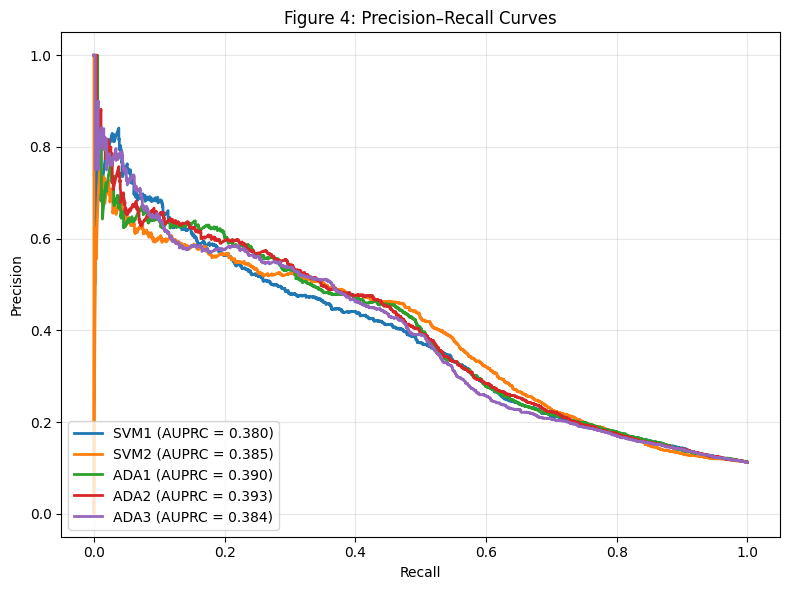

         AUPRC
ADA2  0.393265
ADA1  0.389658
SVM2  0.384800
ADA3  0.383991
SVM1  0.380418


In [240]:
# Plot AUPRC

auprc_results = {}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    # get model prediction scores
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        print(f"{name} cannot compute AUPRC (no probas or decision function)")
        continue

    # compute precision, recall
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)
    auprc_results[name] = avg_precision

    # plot PR curve
    plt.plot(recall, precision, lw=2, label=f'{name} (AUPRC = {avg_precision:.3f})')

# chart formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Figure 4: Precision–Recall Curves')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# create AUPRC summary table
auprc_df = pd.DataFrame.from_dict(auprc_results, orient='index', columns=['AUPRC']).sort_values(by='AUPRC', ascending=False)
print(auprc_df)